In [1]:
import pystan as ps
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import matplotlib as mpl

# used to force examples to run from local copy, rather than installed copy
import os, sys; sys.path.insert(0, os.path.abspath('../'))
import btom as bt

### Single Qubit Example

Define the 'true' state before we begin:

In [2]:
psi = np.array([[1],[1j]])/np.sqrt(2)
rho = np.dot(psi, psi.conj().T)

We will be performing the following measurements:

In [3]:
meas_ops = (bt.pauli_basis()[1:] + np.eye(2)) / 2
meas_ops

Simulate some data based off of the true state using binomial statistics with 500 shots per measurement operator:

In [42]:
data = bt.BinomialTomographyData.simulate(rho, meas_ops, [50,50,50])
print('measurement results: {}'.format(data.results))

measurement results: [30 50 24]


Now we can construct an MCMC sampler with a Ginibre (K=2) prior, and feed this and the data in to get samples from a posterior.

In [5]:
bt.gell_mann_basis(2, normalize=True).expansion(rho)

array([0.70710678+0.j, 0.        +0.j, 0.70710678+0.j, 0.        +0.j])

In [9]:
b = bt.gell_mann_basis(2, normalize=True)
b.expansion(rho)

array([0.70710678+0.j, 0.        +0.j, 0.70710678+0.j, 0.        +0.j])

In [7]:
np.trace(rho)

(0.9999999999999998+0j)

In [8]:
b.expansion(np.eye(2))[0] * b.value[0,...]

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

In [49]:
import statsmodels.api as sm
def mle(self):
    basis = bt.gell_mann_basis(self.dim, normalize=True)
    X = np.real(basis.expansion(self.meas_ops).T)
    
    # estimate of each measurement's overlap with the state
    y = (self.results + 0.5) / (self.n_shots + 1)
    
    # std of each estimate
    w = np.sqrt(y * (1 - y) / self.n_shots)
    
    y /= w
    X = X / w[:,np.newaxis]
    
    # we assume unit trace density matrices, thus we know coeff on this
    # basis element is 1/sqrt(d). thus, subtract it off the RHS to 
    # avoid making it a fit parameter.
    y -= X[:,0] / np.sqrt(self.dim)
    X = X[:,1:]
    
    
    %timeit np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
    %timeit sm.WLS(y * w, X * w[:,np.newaxis], w).fit()
mle(data)

10.8 µs ± 234 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
252 µs ± 9.63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [5]:
sampler = bt.BinomialGinibreStateSampler(ginibre_dim=2, n_chains=4)
posterior = bt.StatePosterior(sampler, data)

Make some plots of the resulting posterior:

(2, 4)


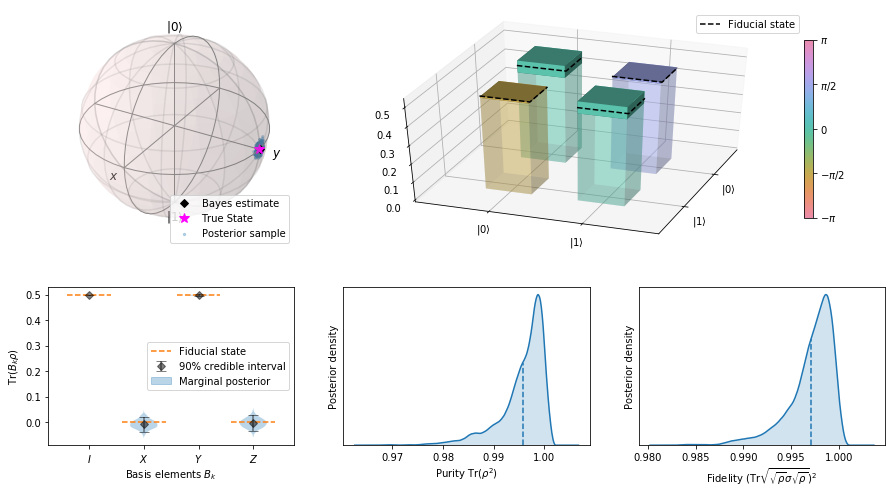

In [6]:
fig = plt.figure(figsize=(15, 8))
gs = mpl.gridspec.GridSpec(2,3, height_ratios=[3,2])

ax_bloch = plt.subplot(gs[0,0], projection='3d')
posterior.plot_bloch(axes=ax_bloch, fiducial_state=rho, fiducial_state_kwargs={'label': 'True State'})

ax_mat = plt.subplot(gs[0,1:3], projection='3d')
posterior.plot_matrix(axes=ax_mat, fiducial_state=rho)

ax_be = plt.subplot(gs[1,0])
posterior.plot_basis_expansion(bt.pauli_basis(), fiducial_state=rho)

ax_purity = plt.subplot(gs[1,1])
posterior.plot_purity()

ax_fidelity = plt.subplot(gs[1,2])
posterior.plot_fidelity(rho)

### Two Qubit Example

Everything is basically the same as above. We use the cat state as our true state, and we measure 15 combinations of Paulis offset by the identity.

In [7]:
psi = np.array([[1],[0],[0],[1]])/np.sqrt(2)
rho = np.dot(psi, psi.conj().T)

meas_ops = (bt.pauli_basis() + np.eye(2))/2
meas_ops = meas_ops.kron(meas_ops)[1:]

Generate the data with binomial sampling at 500 shots per measurement operator.

In [8]:
data = bt.BinomialTomographyData.simulate(rho, meas_ops, 5000)
print('measurement results: {}'.format(data.results))

measurement results: [2436 2475 2494 2498 2506 1276 1235 2530 1284    0 1247 2443 1261 1253
 2529]


Define the sampler and draw posterior samples.

In [9]:
sampler = bt.BinomialGinibreStateSampler(n_chains=4, ginibre_dim=2)
posterior = bt.StatePosterior(sampler, data)

In [10]:
sampler = bt.BinomialGinibreStateSampler(n_chains=4, ginibre_dim=2)
posterior = bt.StatePosterior(sampler, data)

Now let's make a few plots:

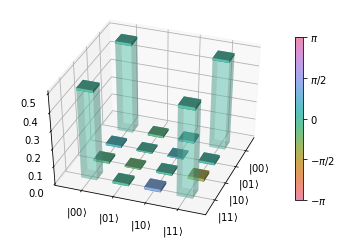

In [15]:
posterior.plot_matrix(vector_basis=bt.canonical_basis([2,2]))

(2, 16)


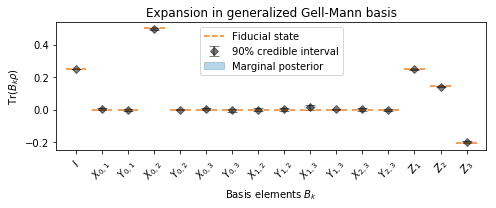

In [12]:
plt.figure(figsize=(7,3))
posterior.plot_basis_expansion(bt.gell_mann_basis(4), fiducial_state=rho)
plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation=50) # rotate tick labels
plt.title('Expansion in generalized Gell-Mann basis')
plt.tight_layout()

(2, 16)


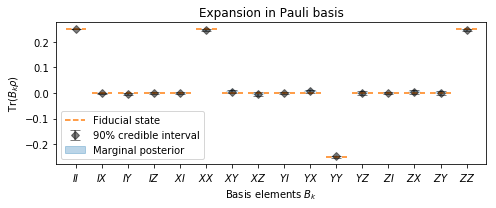

In [13]:
plt.figure(figsize=(7,3))
posterior.plot_basis_expansion(bt.pauli_basis(2), fiducial_state=rho)
plt.title('Expansion in Pauli basis')
plt.tight_layout()

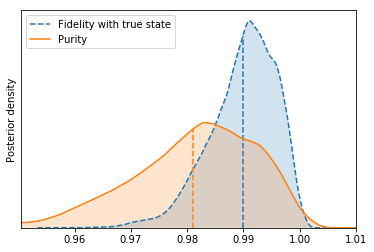

In [14]:
posterior.plot_fidelity(rho, label='Fidelity with true state', ls='--')
posterior.plot_purity(label='Purity')
plt.xlabel('')
plt.legend()

### Four qubit example

In [70]:
n_qubits = 4
psi = np.zeros((2**n_qubits,1), dtype=np.complex)
psi[[0,-1]] = 1 / np.sqrt(2)
rho = np.dot(psi, psi.conj().T)

meas_ops = (bt.pauli_basis(n_qubits)[1:] + np.eye(psi.size)) / 2

In [71]:
data = bt.BinomialTomographyData.simulate(rho, meas_ops, 50000)
print('measurement results: {}'.format(data.results))

measurement results: [24994 24937 25177 24956 25160 25047 25066 25047 25048 25159 24976 24953
 24867 24959 50000 25233 25136 24953 24930 25033 25029 24961 25101 25157
 24785 24807 24997 25003 24921 25064 24964 24912 24882 24847 24914 24952
 25043 25019 25065 25095 25048 25028 25140 24890 25075 25072 24953 24948
 25150 25066 50000 24952 25070 24970 24989 24987 24936 24891 25014 50000
 24847 25119 24893 25086 25065 24959 25024 24665 25009 25097 25014 25081
 25065 25063 24995 24961 25037 25009 25000 24845 24888 25083 24998 25002
 50000 24997 24723 24803 25119     0 25217 24961 25034 25218 25019 25020
 25019 25085 25049 24881 24813     0 25068 24979     0 24960 24848 24806
 25180 24931 24927 24957 24823 24808 24916 24995 25118 24901 24880 24964
 25021 24769 25054 24796 25000 25044 25066 25022 25021 25073 25085 24870
 24911 25224 24979 24960 25151 24910 24846 25005 24978 24822 25065 25137
 25155 25066 25010 24785 24906     0 24990 24918     0 25009 25005 24933
 24799 24998 25181 25056 24957

In [72]:
import statsmodels.api as sm
def mle(self):
    basis = bt.gell_mann_basis(self.dim, normalize=True)
    X = np.real(basis.expansion(self.meas_ops).T)
    
    # estimate of each measurement's overlap with the state
    y = (self.results + 0.5) / (self.n_shots + 1)
    
    # std of each estimate
    w = np.sqrt(y * (1 - y) / self.n_shots)
    
    y /= w
    X = X / w[:,np.newaxis]
    
    # we assume unit trace density matrices, thus we know coeff on this
    # basis element is 1/sqrt(d). thus, subtract it off the RHS to 
    # avoid making it a fit parameter.
    y -= X[:,0] / np.sqrt(self.dim)
    X = X[:,1:]
    
    A = np.dot(np.linalg.inv(np.dot(X.T, X)), X.T)
    
    %timeit -n1 -r3 np.dot(A, y)
    %timeit -n1 -r3 sm.WLS(y * w, X * w[:,np.newaxis], w).fit()
mle(data)

15.5 ms ± 714 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
18.3 ms ± 1.18 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [127]:
sampler = bt.BinomialGinibreStateSampler(n_chains=4, ginibre_dim=1, n_iter=2000)
posterior = bt.StatePosterior(sampler, data)

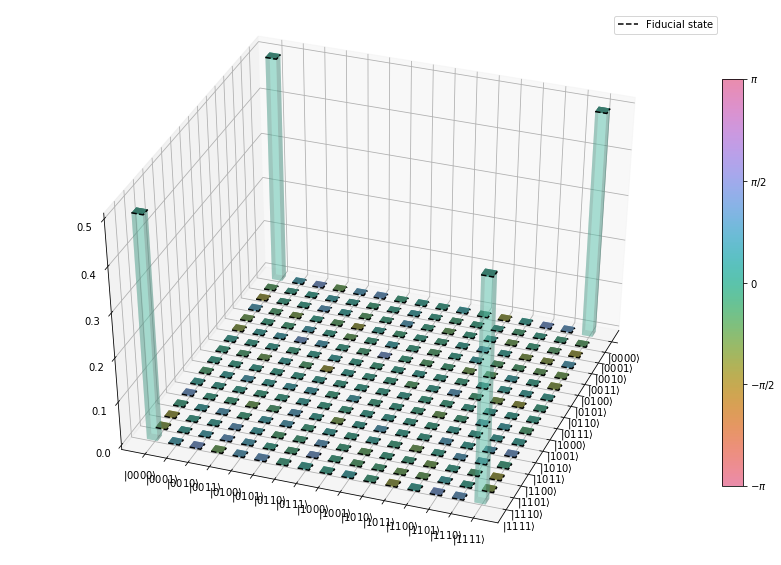

In [129]:
fig = plt.figure(figsize=(15,10))
posterior.plot_matrix(vector_basis=bt.canonical_basis([2,2,2,2]), fiducial_state=rho)